# MIT xPro Deep Learning Capstone
### Anthony Rowlands
### 7/18/2025

This project trains a simple chess engine neural network. It attempts to find the next best move on a chess board, given an initial board state.

## Environment Setup

In [1]:
!pip install gdown
!mkdir -p data
!gdown --id 1-xuXCF0hYq7dBGtuJmVtryCzx9awE29H -O ./data/fics-2024.pgn
!gdown --id 1uG0Cr1MLr5Ds9yK8tN-R3lp6r8t0ZGaB -O ./data/moves_legal_uci.txt
!pip install chess

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-xuXCF0hYq7dBGtuJmVtryCzx9awE29H
To: /content/data/fics-2024.pgn
100% 6.10M/6.10M [00:00<00:00, 38.1MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1uG0Cr1MLr5Ds9yK8tN-R3lp6r8t0ZGaB
To: /content/data/moves_legal_uci.txt
100% 9.49k/9.49k [00:00<00:00, 23.7MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 72.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=be62a1053c7dd55d980903f844523

## Data and Utilities

In [ ]:
import io, json, time, copy, os
from pathlib import Path
from datetime import datetime
from zoneinfo import ZoneInfo
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import chess
import chess.pgn
from typing import List
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm

from google.colab import drive

# Load all possible moves (output layer)
def load_moves():
  global move_to_index, index_to_move
  with open(MOVES_FILE, 'r', encoding='utf-8') as f:
      ALL_MOVES = [line.strip() for line in f.readlines() if line.strip()]
  move_to_index = {m: i for i, m in enumerate(ALL_MOVES)}
  index_to_move = ALL_MOVES

# Load games dataset in PGN format (training data)
def load_games():
  global pgn_lines
  with open(PGN_FILE, 'r', encoding='utf-8', errors='ignore') as f:
      pgn_lines = f.read().splitlines()

# First we parse PGN into a python-chess board, then this encodes it into an tensor for input to the model
def encode_board(board: 'chess.Board') -> torch.Tensor:
    planes = np.zeros((18, 8, 8), dtype=np.float32)
    piece_type_to_index = {
        chess.PAWN: 0,
        chess.KNIGHT: 1,
        chess.BISHOP: 2,
        chess.ROOK: 3,
        chess.QUEEN: 4,
        chess.KING: 5
    }
    for square, piece in board.piece_map().items():
        rank = chess.square_rank(square)
        file = chess.square_file(square)
        base = piece_type_to_index[piece.piece_type]
        channel = base if piece.color == chess.WHITE else base + 6
        planes[channel, 7 - rank, file] = 1.0
    if board.turn == chess.WHITE:
        planes[12, :, :] = 1.0
    if board.has_kingside_castling_rights(chess.WHITE):
        planes[13, :, :] = 1.0
    if board.has_queenside_castling_rights(chess.WHITE):
        planes[14, :, :] = 1.0
    if board.has_kingside_castling_rights(chess.BLACK):
        planes[15, :, :] = 1.0
    if board.has_queenside_castling_rights(chess.BLACK):
        planes[16, :, :] = 1.0
    if board.ep_square is not None:
        r = chess.square_rank(board.ep_square)
        f = chess.square_file(board.ep_square)
        planes[17, 7 - r, f] = 1.0
    return torch.from_numpy(planes)

def collate_batch(batch):
    xs = torch.stack([b[0] for b in batch], dim=0)
    ys = torch.tensor([b[1] for b in batch], dtype=torch.long)
    return xs, ys

def top1_accuracy(logits: torch.Tensor, targets: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    correct = (preds == targets).sum().item()
    total = targets.size(0)
    return correct / total if total > 0 else 0.0

def parse_games_from_pgn_lines(lines: List[str]) -> List['chess.pgn.Game']:
    games = []
    for line in lines:
        if not line.strip():
            continue
        game_io = io.StringIO(line.strip())
        try:
            game = chess.pgn.read_game(game_io)
            if game is not None and game.mainline_moves() is not None:
                games.append(game)
        except Exception:
            pass
    return games

def train_val_test_split(games):
    n = len(games)
    a = int(n * 0.7)
    b = int(n * 0.85)
    return games[:a], games[a:b], games[b:]

class ChessNextMoveDataset(Dataset):
    def __init__(self, games, move_to_index):
        self.games = games
        self.move_to_index = move_to_index
        self.game_moves = [list(g.mainline_moves()) for g in games]
        self.sample_index = []
        for gi, moves in enumerate(self.game_moves):
            for ply_idx, move in enumerate(moves):
                uci = move.uci()
                if uci in self.move_to_index:
                    self.sample_index.append((gi, ply_idx))
    def __len__(self):
        return len(self.sample_index)
    def __getitem__(self, idx):
        gi, ply_idx = self.sample_index[idx]
        moves = self.game_moves[gi]
        board = chess.Board()
        for m in moves[:ply_idx]:
            board.push(m)
        x = encode_board(board)
        y = self.move_to_index[moves[ply_idx].uci()]
        return x, y

def build_loaders(train_games, val_games, test_games, batch_size=256, num_workers=0):
    train_ds = ChessNextMoveDataset(train_games, move_to_index)
    val_ds = ChessNextMoveDataset(val_games, move_to_index)
    test_ds = ChessNextMoveDataset(test_games, move_to_index)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_batch)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_batch)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_batch)
    return {'train': train_loader, 'val': val_loader, 'test': test_loader}, {'train': len(train_ds), 'val': len(val_ds), 'test': len(test_ds)}

def load_model():
    global model, training_curves, best_epoch, dataloaders, dataset_sizes
    print(f'Loading existing model from {LOAD_MODEL_FILE}')
    drive.mount('/content/drive')
    games = parse_games_from_pgn_lines(pgn_lines)
    train_games, val_games, test_games = train_val_test_split(games)
    dataloaders, dataset_sizes = build_loaders(train_games, val_games, test_games)
    checkpoint = torch.load(f'{MODELS_DIR}/{LOAD_MODEL_FILE}', map_location=device)
    model = NextMoveCNN(num_moves=len(index_to_move)).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    training_curves = {'train_loss': [], 'val_loss': [], 'test_loss': [], 'train_acc': [], 'val_acc': [], 'test_acc': []}
    with open(LOAD_CURVES_FILE) as f:
        training_curves = json.load(f)
    best_epoch = int(checkpoint.get('best_epoch', 0))
    print(f'Loaded existing model')

def train_model():
    global model, training_curves, best_epoch, dataloaders, dataset_sizes
    print('Training new model')
    def fmt(elapsed):
        m = int(elapsed // 60)
        s = int(elapsed % 60)
        return f"{m}min {s}sec"
    overall_start = time.time()
    tz = ZoneInfo('America/Denver')
    print(f"Train start: {datetime.now(tz).isoformat(timespec='seconds')}")
    games = parse_games_from_pgn_lines(pgn_lines)
    train_games, val_games, test_games = train_val_test_split(games)
    dataloaders, dataset_sizes = build_loaders(train_games, val_games, test_games)
    model = NextMoveCNN(num_moves=len(index_to_move)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
    phases = ['train', 'val', 'test']
    training_curves = {}
    for p in phases:
        training_curves[p + '_loss'] = []
        training_curves[p + '_acc'] = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    best_epoch_local = 0
    num_epochs = 5
    for epoch in range(1, num_epochs + 1):
        epoch_start = time.time()
        print(f"Epoch {epoch} start: {datetime.now(tz).isoformat(timespec='seconds')}")
        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            count = 0
            pbar = tqdm(dataloaders[phase], desc=f"{phase} {epoch}/{num_epochs}", leave=False)
            for i, (xb, yb) in enumerate(pbar, 1):
                xb = xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad(set_to_none=True)
                with torch.set_grad_enabled(phase == 'train'):
                    logits = model(xb)
                    loss = criterion(logits, yb)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                preds = torch.argmax(logits, dim=1)
                running_loss += loss.item() * xb.size(0)
                running_corrects += (preds == yb).sum().item()
                count += xb.size(0)
                if count > 0:
                    pbar.set_postfix(loss=round(running_loss / count, 4), acc=round(running_corrects / count, 4), it=i)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / count if count > 0 else 0.0
            epoch_acc = running_corrects / count if count > 0 else 0.0
            training_curves[phase + '_loss'].append(epoch_loss)
            training_curves[phase + '_acc'].append(epoch_acc)
            if phase == 'val' and epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_epoch_local = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
        elapsed = time.time() - epoch_start
        print(f"Epoch {epoch} end: {datetime.now(tz).isoformat(timespec='seconds')} elapsed: {fmt(elapsed)}")
        tr_loss = training_curves['train_loss'][-1]
        tr_acc = training_curves['train_acc'][-1]
        va_loss = training_curves['val_loss'][-1]
        va_acc = training_curves['val_acc'][-1]
        te_loss = training_curves['test_loss'][-1]
        te_acc = training_curves['test_acc'][-1]
        print(f"Epoch {epoch} metrics: train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f} | test loss {te_loss:.4f} acc {te_acc:.4f}")
    model.load_state_dict(best_model_wts)
    best_epoch = best_epoch_local
    total_elapsed = time.time() - overall_start
    print(f"Train end: {datetime.now(tz).isoformat(timespec='seconds')} elapsed: {fmt(total_elapsed)}")
    model.eval()
    test_start = time.time()
    print(f"Test start: {datetime.now(tz).isoformat(timespec='seconds')}")
    test_all_preds = []
    test_all_trues = []
    with torch.no_grad():
        pbar = tqdm(dataloaders['test'], desc="test", leave=False)
        running = 0
        for i, (xb, yb) in enumerate(pbar, 1):
            xb = xb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1).cpu().numpy().tolist()
            test_all_preds.extend(preds)
            test_all_trues.extend(yb.numpy().tolist())
            running += xb.size(0)
            pbar.set_postfix(samples=running, it=i)
    test_elapsed = time.time() - test_start
    print(f"Test end: {datetime.now(tz).isoformat(timespec='seconds')} elapsed: {fmt(test_elapsed)}")
    training_curves['test_all_preds'] = test_all_preds
    training_curves['test_all_trues'] = test_all_trues
    print('New model trained successfully')

def draw_training_curves():
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(training_curves['train_loss'], label='train')
    plt.plot(training_curves['val_loss'], label='val')
    plt.plot(training_curves['test_loss'], label='test')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(training_curves['train_acc'], label='train')
    plt.plot(training_curves['val_acc'], label='val')
    plt.plot(training_curves['test_acc'], label='test')
    plt.title('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

def draw_confusion_matrix():
    all_preds = training_curves.get('test_all_preds')
    all_trues = training_curves.get('test_all_trues')
    num_classes = len(index_to_move)
    counts_true = np.bincount(np.array(all_trues), minlength=num_classes)
    counts_pred = np.bincount(np.array(all_preds), minlength=num_classes)
    valid_indices = np.where((counts_true + counts_pred) > 0)[0].tolist()
    removed = num_classes - len(valid_indices)
    print({'removed_classes': int(removed), 'kept_classes': int(len(valid_indices))})
    cm = confusion_matrix(all_trues, all_preds, labels=valid_indices)
    cm_plot = cm.astype(float)
    cm_plot[cm_plot == 0] = np.nan
    plt.figure(figsize=(20, 20), dpi=100)
    im = plt.imshow(cm_plot, aspect='auto', interpolation='nearest', cmap='RdYlGn', norm=LogNorm(vmin=1, vmax=np.nanmax(cm_plot)))
    plt.title('Confusion matrix (filtered moves)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.colorbar(im)
    plt.show()

## Globals

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_epoch = 0
training_curves = {}

model = None
dataloaders = None
dataset_sizes = None

pgn_lines = []
move_to_index = {}
index_to_move = []

LOAD_EXISTING_MODEL = True

DATA_DIR = Path('data')
MODELS_DIR = '/content/drive/MyDrive/MIT xPro Deep Learning/Capstone/models'
LOAD_MODEL_FILE = 'model.pt'
LOAD_CURVES_FILE = f'{MODELS_DIR}/training_curves.json'
MOVES_FILE = DATA_DIR.joinpath('moves_legal_uci.txt')
PGN_FILE = DATA_DIR.joinpath('fics-2024.pgn')


## Model

In [ ]:
class NextMoveCNN(nn.Module):
    def __init__(self, num_moves: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(18, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2 * 2, 512),
            nn.ReLU(),
            nn.Linear(512, num_moves)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


## Main - Train or Load

In [ ]:
load_moves()
load_games()

if LOAD_EXISTING_MODEL:
  load_model()
else:
  train_model()


## Analyze

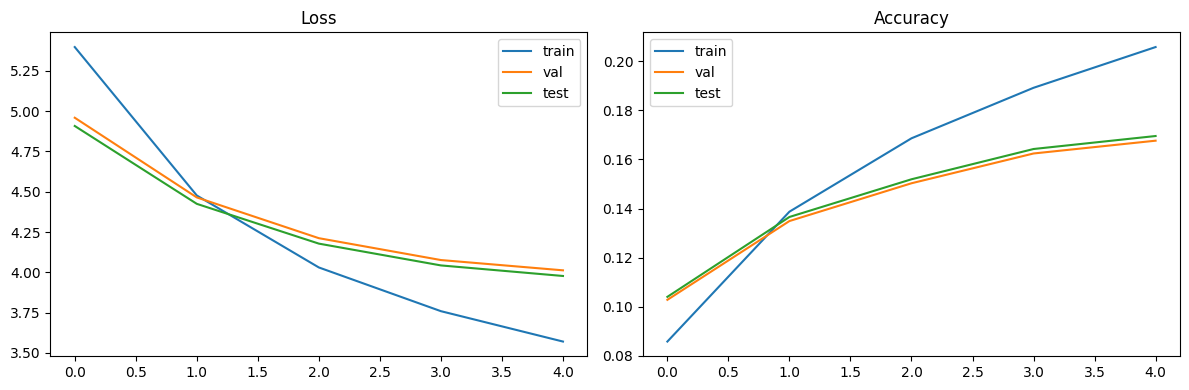

{'cm_shape': (1880, 1880), 'total': 137600, 'nonzero': 65891}


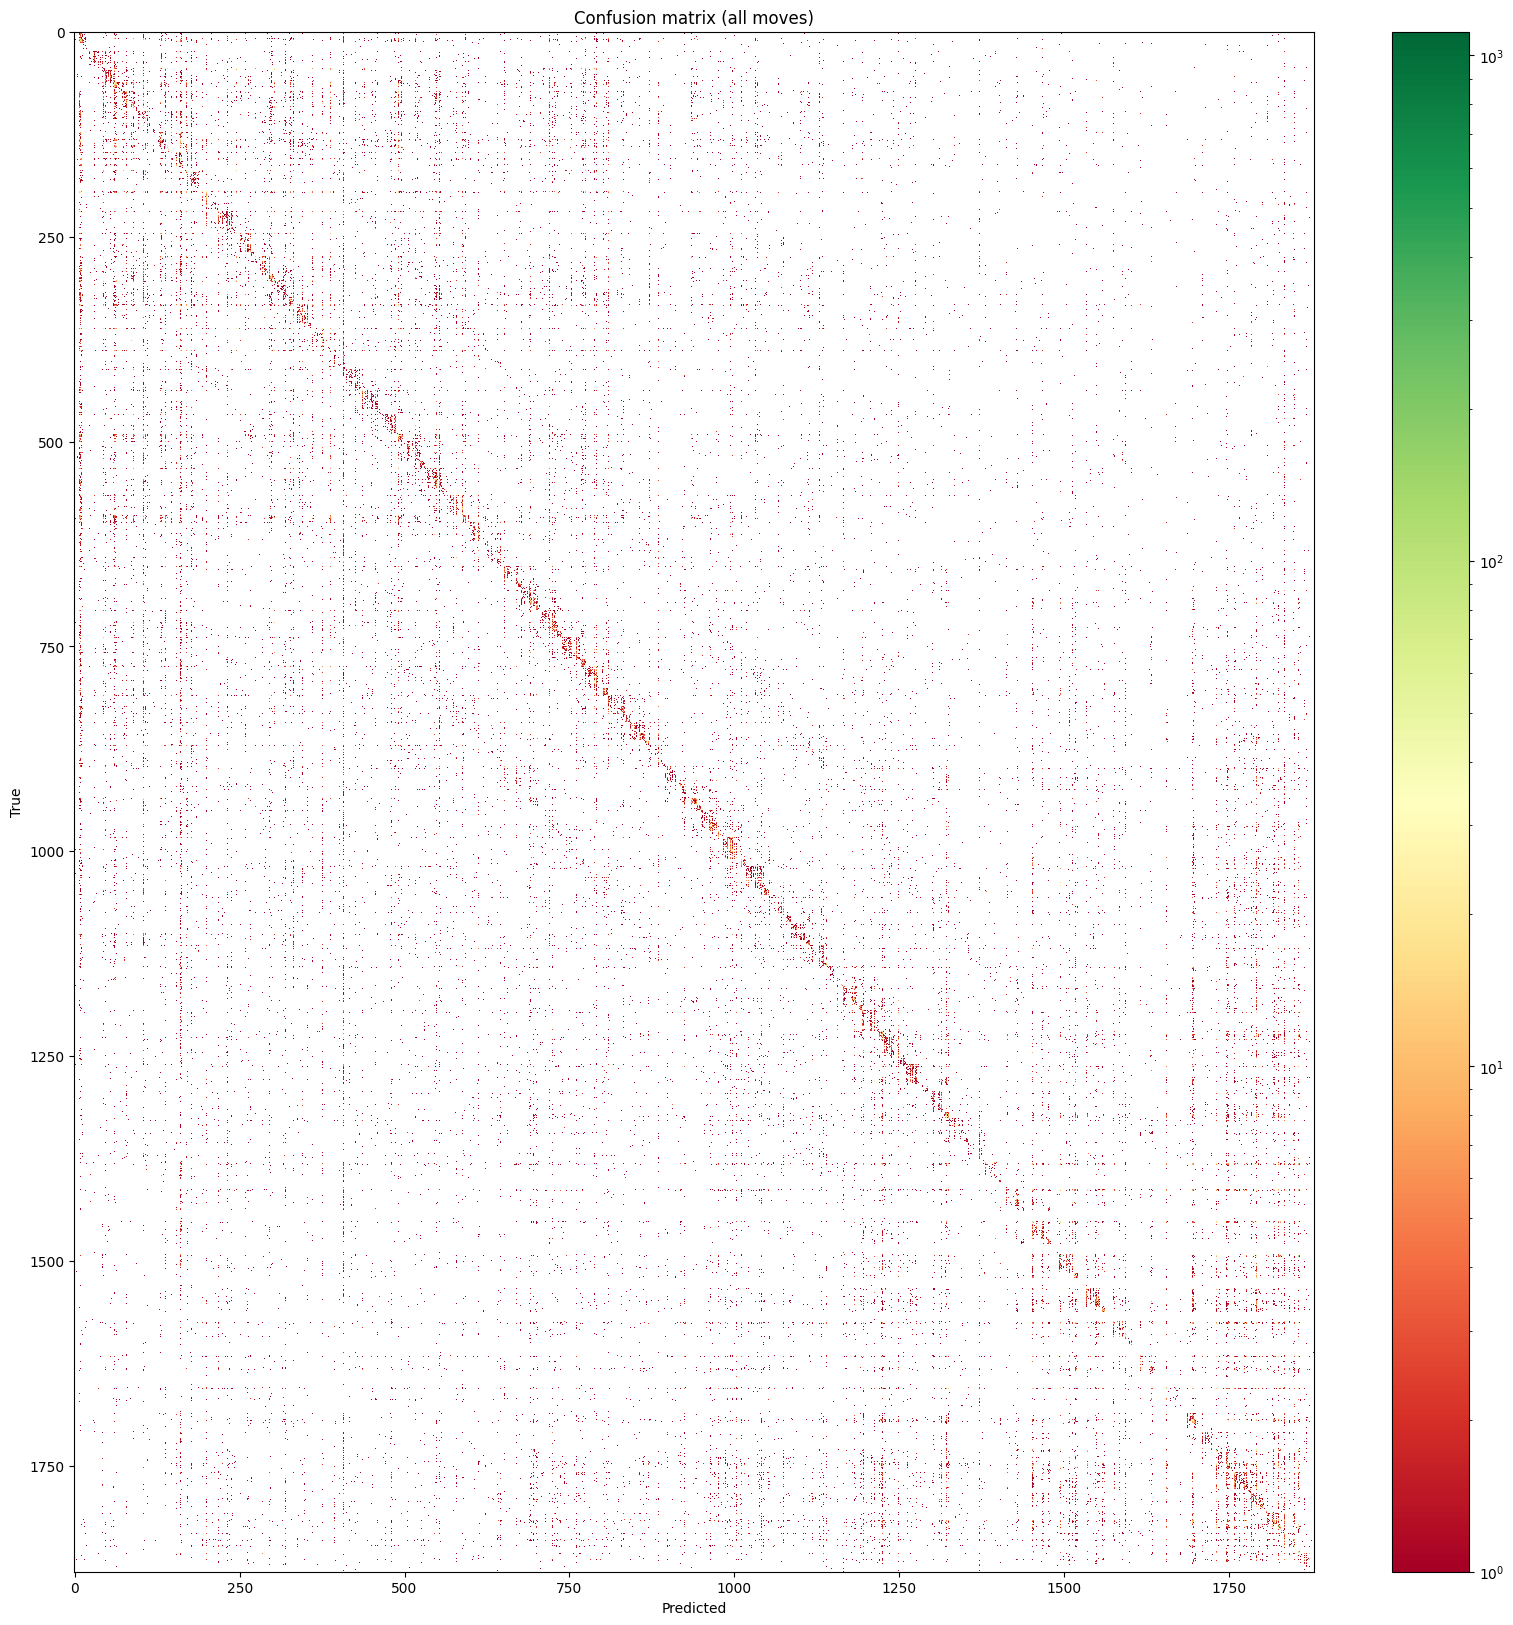

In [ ]:
draw_training_curves()
draw_confusion_matrix()

## Manual Test Specific Moves

In [ ]:
def predict_next_move_from_pgn(pgn_moves_text: str) -> str:
    game_io = io.StringIO(pgn_moves_text.strip())
    game = chess.pgn.read_game(game_io)
    if game is None:
        return ''
    board = chess.Board()
    for m in game.mainline_moves():
        board.push(m)
    x = encode_board(board).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0]
        sorted_indices = torch.argsort(probs, dim=0, descending=True).cpu().tolist()
        for idx in sorted_indices:
            uci = index_to_move[idx]
            try:
                move = chess.Move.from_uci(uci)
            except Exception:
                continue
            if board.is_legal(move):
                return uci
    raise Exception('Model did not produce any legal move for the given position')

print(predict_next_move_from_pgn("1. d4 d5 2. Nf3 Nf6 3. g3 Bf5 4. Bg2 e6 5. c4 c6 6. Nc3 h6 7. O-O Be7 8. Nd2 O-O 9. e4 dxe4 10. Ndxe4 Nbd7"))


## Save Model to Drive

In [ ]:
def save_to_drive():
    drive.mount('/content/drive')
    os.makedirs(MODELS_DIR, exist_ok=True)

    model_timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
    model_path = f'{MODELS_DIR}/model-{model_timestamp}.pt'
    curves_path = f'{MODELS_DIR}/training_curves-{model_timestamp}.json'

    torch.save({'model_state_dict': model.state_dict(), 'num_moves': len(index_to_move), 'best_epoch': best_epoch}, model_path)
    with open(curves_path, 'w') as f:
        json.dump(training_curves, f)

save_to_drive()
